# Disaster Reponse Pipeline Creation 


### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [4]:
import sys; sys.executable

'C:\\Users\\jwilliams1\\AppData\\Local\\Continuum\\anaconda3\\python.exe'

In [5]:
! {sys.executable} -m pip install scikit-multilearn
! {sys.executable} -m pip install arf

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# import libraries
import pandas as pd
import sqlite3
import re

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from skmultilearn.model_selection import iterative_train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# load data from database
engine = create_engine('sqlite:///DisasterMessages.db')
df = pd.read_sql('SELECT * FROM CleanMessages', engine)

# define variables. X is input, Y is target
X = df['message']
Y = df.drop(['id', 'message', 'original', 'genre'], axis=1) 

In [8]:
# drop the 'child alone' tag because there are no messages with this tag.
Y = Y.drop('child_alone', axis=1)

# replace 2's with 1's in the related field
Y.loc[Y.related == 2, 'related'] = 1

In [10]:
# original data
df.head(5)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# how many in original data are related=2
(df.related == 2).sum()

188

In [12]:
# check out the shape of the data
X.shape, Y.shape

((26216,), (26216, 35))

#### We have 26k messages with 35 possible labels

### 2. Write a tokenization class to process the text data

In [13]:
# define a function that will allow a treebank POS tag to be converted into a WordNet
# POS Tag so the lemmatizer will understand it
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    # default to Noun 
    else:
        return wordnet.NOUN

We will implement a custom transformer with hyperparameters in order to determine if removing stop words and/or lemmatizing words will have a positive effect on classification efficacy.
This custom transformer follows sklearn's rules for transformers so that it can be used in our processing pipeline.

In [14]:
# implement a custom transformer to determine if removing stops and/or lemmatizing improves model performance

class MessageTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, remove_stops=True, lemmatize=True):
        self.remove_stops = remove_stops
        self.lemmatize = lemmatize
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        
        # iterate over supplied messages
        for text in X: 
            # remove all non-alphanumeric characters
            text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
              
            # lower and strip whitespace
            text = text.lower().strip()
    
            # tokenize words - nltk.tokenize.word_tokenize
            words = word_tokenize(text)
            
            if self.lemmatize:
                # tag words with Part of Speech - list of (word, POS) tuples 
                # nltk.pos_tag()
                words_with_pos_tag = pos_tag(words)
                
                if self.remove_stops:
                    # remove stop words
                    # stop_words = nlt.corpus.stopwords of 'english' language
                    words_with_pos_tag = [word for word in words_with_pos_tag if word[0] not in stop_words]
                
                # change pos tags to wordnet pos tags for lemmatizer
                words_with_wordnet_tag = []
    
                for word_with_tag in words_with_pos_tag:
                    word, tag = word_with_tag
                    tag = get_wordnet_pos(tag)
                    words_with_wordnet_tag.append((word, tag))

                # lemmatize
                lemm = WordNetLemmatizer()
                # unpack the (word, pos) tuple into the Lemmatizer to give better lemmatization 
                # lemmatization is more effective when it knows the correct part of speech
                words = [lemm.lemmatize(*w) for w in words_with_wordnet_tag]
                
            else:
                if self.remove_stops:
                    words = [word for word in words if word not in stop_words]

            # join cleaned words back into single document
            X_transformed.append(' '.join(words))
        
        return X_transformed    

Show off the custom transformer

In [15]:
text = ["We would not want these words taking up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words"]
text.append("Here is another example of words. Isn't it great how words are?")

text

['We would not want these words taking up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words',
 "Here is another example of words. Isn't it great how words are?"]

In [16]:
MessageTokenizer(remove_stops=False, lemmatize=True).transform(text)

['we would not want these word take up space in our database or take up valuable processing time for this we can remove them easily by store a list of word that you consider to be stop word',
 'here be another example of word isn t it great how word be']

### 3. Build a first machine learning pipeline
A pipeline allows us to wrap all of our data transformation steps into a neat little package.

In [17]:
pipeline = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', RandomForestClassifier())
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

Since this is a multilabel classification, I looked into the iterative train-test-split supplied by skmultilearn.
The idea with the iterative train test split is that in theory it can provide better label representation for mutli label problems. Here I will compare whether this train test split results in appropriate label representation for the train set.

In [18]:
# get the proportion of labels in the original data
compare = pd.DataFrame(Y.mean(axis=0), columns=['dataset'])

In [19]:
compare.head()

,dataset
related,0.766478
request,0.170659
offer,0.004501
aid_related,0.414251
medical_help,0.079493


In [20]:
# employ skmultilearn's iterative train test split.
# have to reshape the X values to be multidimensional since that's what this expects

X_train, y_train, X_test, y_test = iterative_train_test_split(X.values.reshape(-1,1), Y.values, test_size = 0.25)

In [21]:
# we want to see how the iterative split did with label proportions
compare['train_set'] = y_train.mean(axis=0)

In [22]:
# normal train test split - how does it compare
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.25)

In [23]:
compare['normal_split'] = y_train2.values.mean(axis=0)

In [24]:
compare

,dataset,train_set,normal_split
related,0.766478,0.766453,0.767521
request,0.170659,0.135388,0.170430
offer,0.004501,0.004221,0.004883
aid_related,0.414251,0.414251,0.415166
medical_help,0.079493,0.087784,0.080714
medical_products,0.050084,0.053148,0.049690
search_and_rescue,0.027617,0.028532,0.027973
security,0.017966,0.019327,0.017750
military,0.032804,0.041247,0.032703
water,0.063778,0.062608,0.063981


In [25]:
diff = pd.DataFrame(compare['dataset'] - compare['normal_split'])
diff.columns = ['dataset - normalsplit']
diff['dataset - iterative split'] = compare['dataset'] - compare['train_set']
diff = diff.abs()

diff

,dataset - normalsplit,dataset - iterative split
related,0.001043,0.000025
request,0.000229,0.035271
offer,0.000381,0.000280
aid_related,0.000915,0.000000
medical_help,0.001221,0.008290
medical_products,0.000394,0.003064
search_and_rescue,0.000356,0.000915
security,0.000216,0.001360
military,0.000102,0.008443
water,0.000203,0.001170


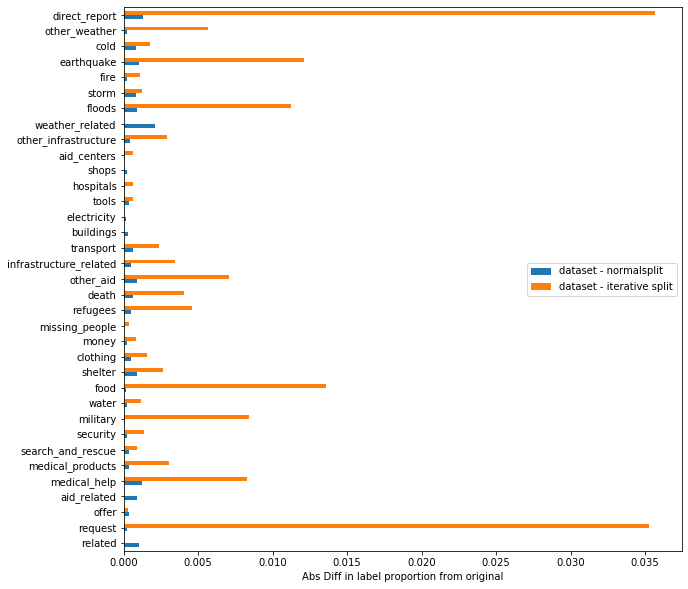

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10,10))
diff.plot(kind='barh', ax=ax)
plt.xlabel('Abs Diff in label proportion from original')
plt.show()


It seems that the normal train-test-split does a fine, if not better job, of capturing nearly the same proportion of labels as in the original dataset

In [29]:
# normal train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [30]:
# fit the pipeline!
pipeline.fit(X_train, y_train)

C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('msg_tokenizer', MessageTokenizer(lemmatize=True, remove_stops=True)), ('count_vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [25]:
#MessageTokenizer(remove_stops=True, lemmatize=True).transform(X_train.reshape(-1,))

### 5. Test the fitted model on the train data
We'll save the test data for the very end.

In [31]:
y_pred = pipeline.predict(X_train)

In [37]:
y_prob = pipeline.predict_proba(X_train)

In [32]:
# iterate thru all the labels and check the accuracy on each label

y_pred = pd.DataFrame(y_pred, columns=Y.columns)
y_train = pd.DataFrame(y_train, columns=Y.columns)

for col in Y.columns:
    print(col, '\n', classification_report(y_pred[col], y_train[col]))

related 
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4613
         1.0       0.99      0.99      0.99     15049

   micro avg       0.99      0.99      0.99     19662
   macro avg       0.99      0.99      0.99     19662
weighted avg       0.99      0.99      0.99     19662

request 
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     16574
         1.0       0.92      1.00      0.96      3088

   micro avg       0.99      0.99      0.99     19662
   macro avg       0.96      0.99      0.98     19662
weighted avg       0.99      0.99      0.99     19662

offer 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19601
         1.0       0.76      1.00      0.87        61

   micro avg       1.00      1.00      1.00     19662
   macro avg       0.88      1.00      0.93     19662
weighted avg       1.00      1.00      1.00   

direct_report 
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     16183
         1.0       0.91      1.00      0.95      3479

   micro avg       0.98      0.98      0.98     19662
   macro avg       0.96      0.99      0.97     19662
weighted avg       0.98      0.98      0.98     19662



In [28]:
from sklearn.metrics import confusion_matrix

for col in Y.columns:
    print(col, '\n', confusion_matrix(y_pred[col], y_train[col]))
    print('\n')

related 
 [[ 4453    83]
 [   64 15062]]


request 
 [[16271   237]
 [   11  3143]]


offer 
 [[19569    28]
 [    0    65]]


aid_related 
 [[11440   299]
 [   17  7906]]


medical_help 
 [[18099   265]
 [    1  1297]]


medical_products 
 [[18678   155]
 [    1   828]]


search_and_rescue 
 [[19129   109]
 [    2   422]]


security 
 [[19294   102]
 [    2   264]]


military 
 [[18989   113]
 [    0   560]]


water 
 [[18400    77]
 [    0  1185]]


food 
 [[17429   151]
 [    2  2080]]


shelter 
 [[17930   166]
 [    4  1562]]


clothing 
 [[19351    57]
 [    0   254]]


money 
 [[19199   102]
 [    1   360]]


missing_people 
 [[19432    55]
 [    1   174]]


refugees 
 [[18996   136]
 [    1   529]]


death 
 [[18746   151]
 [    1   764]]


other_aid 
 [[17083   413]
 [    5  2161]]


infrastructure_related 
 [[18360   267]
 [    1  1034]]


transport 
 [[18748   184]
 [    2   728]]


buildings 
 [[18637   168]
 [    1   856]]


electricity 
 [[19268    82]
 [    0   312]]


t

The performance of the classifier on the training data seems fairly good overall.
Another way to gauge the results of a multi-label output is by computing the hamming loss.
Hamming loss is the fraction of labels that are incorrectly predicted, i.e., the fraction of the wrong labels to the total number of labels.

In [33]:
# compute hamming loss as well
from sklearn.metrics import hamming_loss, make_scorer

# drop related column while measuring this because there are some rows with related=2
print('Hamming loss: ', hamming_loss(y_train, y_pred))

Hamming loss:  0.007662350872604153


In [31]:
# fit and predict on the iterative split to see if it performs better
pipeline2 = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', RandomForestClassifier())
])

X_train2, y_train2, X_test2, y_test2 = iterative_train_test_split(X.values.reshape(-1,1), Y.values, test_size = 0.25)

pipeline2.fit(X_train.values.reshape(-1,), y_train2)

/home/james/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('msg_tokenizer',
                 MessageTokenizer(lemmatize=True, remove_stops=True)),
                ('count_vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_ac...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                               

In [32]:
y_pred2 = pipeline.predict(X_train2.reshape(-1,))
y_pred2 = pd.DataFrame(y_pred2, columns=Y.columns)
y_train2 = pd.DataFrame(y_train2, columns=Y.columns)

for col in Y.columns:
    print(col, '\n', classification_report(y_pred2[col], y_train2[col]))

related 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      4395
           1       0.97      0.96      0.97     15267

    accuracy                           0.95     19662
   macro avg       0.92      0.94      0.93     19662
weighted avg       0.95      0.95      0.95     19662

request 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     17459
           1       0.79      0.96      0.86      2203

    accuracy                           0.97     19662
   macro avg       0.89      0.96      0.92     19662
weighted avg       0.97      0.97      0.97     19662

offer 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19614
           1       0.53      1.00      0.70        48

    accuracy                           1.00     19662
   macro avg       0.77      1.00      0.85     19662
weighted avg       1.00      1.00      1.00   

cold 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     19394
           1       0.62      0.99      0.76       268

    accuracy                           0.99     19662
   macro avg       0.81      0.99      0.88     19662
weighted avg       0.99      0.99      0.99     19662

other_weather 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     18949
           1       0.62      0.99      0.76       713

    accuracy                           0.98     19662
   macro avg       0.81      0.98      0.87     19662
weighted avg       0.99      0.98      0.98     19662

direct_report 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     17209
           1       0.75      0.96      0.84      2453

    accuracy                           0.96     19662
   macro avg       0.87      0.96      0.91     19662
weighted avg       0.96      0.96  

In [33]:
hamming_loss(y_train2, y_pred2)

0.02043826380109566

Again, doesn't seem to be any advantage to it - precision is lower and hamming loss is higher. 

### Test three different classifiers before tuning hyper params

We will test out a 
1. Multilayer Perceptron - Directly supports multi-label - <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier"> link </a>
2. RidgeClassifierCV <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html#sklearn.linear_model.RidgeClassifierCV"> link </a>
3. A LinearSVC wrapped in OneVsRestClassifier. In essence, train a separate model to predict for each individual label. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html"> LinearSVC link </a> and <a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html"> OneVsRest link </a>

In [43]:
# import them

from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [49]:
# a quick and dirty function to look at model results
from sklearn.metrics import confusion_matrix

def model_compare(y_pred, y_train):
    y_pred2 = pd.DataFrame(y_pred, columns=Y.columns)
    y_train2 = pd.DataFrame(y_train, columns=Y.columns)

    for col in Y.columns:
        print(col, '\n', classification_report(y_pred2[col], y_train2[col]))
        
        print('\n', confusion_matrix(y_pred2[col], y_train2[col]))
        
    print(f"Hamming Loss: {hamming_loss(y_pred, y_train)}")
    

In [47]:
pipeline_svc = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', OneVsRestClassifier(SVC(kernel='linear')))
])

pipeline_svc.fit(X_train, y_train)
y_pred_svc = pipeline_svc.predict(X_train)



In [50]:
model_compare(y_pred_svc, y_train)

related 
               precision    recall  f1-score   support

           0       0.73      0.88      0.80      3830
           1       0.97      0.92      0.95     15832

   micro avg       0.91      0.91      0.91     19662
   macro avg       0.85      0.90      0.87     19662
weighted avg       0.92      0.91      0.92     19662


 [[ 3379   451]
 [ 1230 14602]]
request 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     17157
           1       0.68      0.90      0.77      2505

   micro avg       0.93      0.93      0.93     19662
   macro avg       0.83      0.92      0.87     19662
weighted avg       0.95      0.93      0.94     19662


 [[16078  1079]
 [  247  2258]]
offer 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19661
           1       0.01      1.00      0.02         1

   micro avg       1.00      1.00      1.00     19662
   macro avg       0.51      1.00 

C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


aid_centers 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     19658
           1       0.02      1.00      0.03         4

   micro avg       0.99      0.99      0.99     19662
   macro avg       0.51      0.99      0.51     19662
weighted avg       1.00      0.99      0.99     19662


 [[19426   232]
 [    0     4]]
other_infrastructure 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     19641
           1       0.02      1.00      0.05        21

   micro avg       0.96      0.96      0.96     19662
   macro avg       0.51      0.98      0.51     19662
weighted avg       1.00      0.96      0.98     19662


 [[18782   859]
 [    0    21]]
weather_related 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     14810
           1       0.82      0.92      0.87      4852

   micro avg       0.93      0.93      0.93     19662
   macr

In [52]:
pipeline_mlp = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', MLPClassifier())
])

pipeline_mlp.fit(X_train, y_train)
y_pred_mlp = pipeline_mlp.predict(X_train)

model_compare(y_pred_mlp, y_train)

C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


related 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4614
           1       1.00      1.00      1.00     15048

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      0.99      1.00     19662
weighted avg       1.00      1.00      1.00     19662


 [[ 4577    37]
 [   32 15016]]
request 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16339
           1       0.99      1.00      1.00      3323

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      1.00      1.00     19662
weighted avg       1.00      1.00      1.00     19662


 [[16316    23]
 [    9  3314]]
offer 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19583
           1       0.99      1.00      0.99        79

   micro avg       1.00      1.00      1.00     19662
   macro avg       0.99      1.00 


 [[19551     1]
 [    0   110]]
hospitals 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19443
           1       1.00      1.00      1.00       219

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      1.00      1.00     19662
weighted avg       1.00      1.00      1.00     19662


 [[19443     0]
 [    0   219]]
shops 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19569
           1       1.00      1.00      1.00        93

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      1.00      1.00     19662
weighted avg       1.00      1.00      1.00     19662


 [[19569     0]
 [    0    93]]
aid_centers 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19426
           1       1.00      1.00      1.00       236

   micro avg       1.00      1.00      1.00     1

Hmmmmmmmmmmm. Looks like that neural net is way overfitting

0.8% of labels are predicted incorrectly with RF

The SVC Classifier is not as good at distinguishing between the majority and the minority classes. Accuracy on the individual labels is worse, and Hamming score is worse.

In [98]:
# tune the grid with hamming loss  - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html
# make a custom scorer https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
from sklearn.metrics import hamming_loss, make_scorer
hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)


In [ ]:
# create a DenseTranformer class to make sure the output is correct for the GaussianNB

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [ ]:
pipeline_nb = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer(tokenizer=tokenize)),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # make sure the output is dense, not sparse - needed for GaussianNB
    ('dense', DenseTransformer()),
    # classifier - one classifier per label
    ('clf', MultiOutputClassifier(estimator=GaussianNB()))
])

pipeline_nb.fit(X_train.values, y_train)
y_pred_nb = pipeline_nb.predict(X_train.values)

model_compare(y_pred_nb, y_train)

Choosing to go with the RandomForest model because it seems to yield the best results on training set.

### 6. Improve your model
Use grid search to find better parameters. 

In [1]:
search_params = {
    'msg_tokenizer__remove_stops': [False, True],
    'msg_tokenizer__lemmatize': [False, True],
    'count_vec__ngram_range': [(1,1), (1,2), (1,3)],
    'count_vec__max_features': [None, 100, 500, 1000],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__use_idf': [False, True],
    'tfidf__smooth_idf': [False, True],
    'clf__estimator__n_estimators': [10, 100, 500],
    'clf__estimator__max_depth': [None, 50, 100, 500],
    'clf__estimator__bootstrap': [True, False],
    'clf__estimator__class_weight': [None, 'balanced']
}

cv = RandomizedSearchCV(pipeline, search_params, n_iter=5, n_jobs=-1, scoring=hamming_scorer)
search = cv.fit(X_train, y_train)

NameError: name 'RandomizedSearchCV' is not defined

In [ ]:
cv2 = RandomizedSearchCV(pipeline, search_params, n_iter=10, n_jobs=-1, scoring=hamming_score)
search2 = cv.fit(X_train, y_train)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.